In [12]:
# Victor Z, Jaron T
# UW-Madison, 2024
# regularization for Gibbs reactor

In [13]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd

In [14]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [15]:
# Function definitions
def msefun(theta, dat):
    yhat = dat['X'].dot(theta)
    return np.mean((yhat - dat['y'])**2)

def rhofun(theta):
    return np.sum(np.abs(theta))

def myfun(theta, dat):
    X = dat['X']
    y = dat['y']
    yhat = X.dot(theta)
    MSE = np.mean((yhat - y)**2)
    rho = np.sum(np.abs(theta))
    return MSE + dat['kappa'] * rho

In [33]:
# Load data
path = '/content/drive/MyDrive/StatsBookCode/Python/'
filename=path+'/Data/gibbs_covariance.dat'
datat = np.loadtxt(filename)

filename=path+'/Data/gibbs_lowtemp_class.dat'
datan = np.loadtxt(filename)
data = np.hstack((datat, datan[:, :1]))

# Construct input-output data matrices
Y = data[:, 1]
X = data[:, [0, 2, 3, 4]]

# Perturb data with noise
np.random.seed(1)
Y += np.random.normal(0, 0.05, Y.shape)

# Scale data
mu = np.mean(X, axis=0)
sig = np.std(X, axis=0)
X = (X - mu) / sig

# Add intercept term
X = np.hstack((np.ones((X.shape[0], 1)), X))

          0
0  0.690337
1  0.021850
2 -0.048682
3  0.000000
4  0.031250


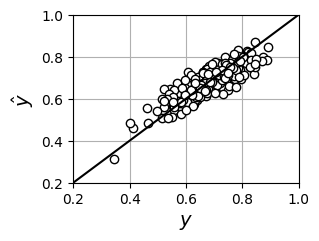

In [34]:
# Solve estimation problem
dat = {'y': Y, 'X': X, 'kappa': 0}
theta_initial = np.ones(X.shape[1])
result = minimize(myfun, theta_initial, args=(dat,), method='trust-constr', options={'disp': False})
thetahat = result.x

# Evaluate fit
MSE = msefun(thetahat, dat)

# Compare predictions and observations
Yhat = X.dot(thetahat)
plt.figure(1)
plt.subplot(2, 2, 1)
plt.plot(Y, Yhat, 'o', markerfacecolor='w', color='black')
plt.plot([0, 1], [0, 1], 'k-')
plt.grid(True)
plt.xlabel('$y$', fontsize=14)
plt.ylabel('$\hat{y}$', fontsize=14)
plt.axis([0.2, 1, 0.2, 1])

# Compare with analytical solution
thetan = np.linalg.inv(X.T.dot(X)).dot(X.T.dot(Y))
MSEn = msefun(thetan, dat)

print(pd.DataFrame(thetan))

In [35]:
# Get Hessian
H = X.T.dot(X)
lam = np.linalg.eigvals(H)

print(pd.DataFrame(H))
print(pd.DataFrame(lam))

              0             1             2             3             4
0  2.500000e+02 -3.907985e-14  7.871481e-14  4.242162e-13 -4.382050e-13
1 -3.907985e-14  2.500000e+02 -2.439193e+02 -2.439193e+02  2.439193e+02
2  7.871481e-14 -2.439193e+02  2.500000e+02  2.500000e+02 -2.500000e+02
3  4.242162e-13 -2.439193e+02  2.500000e+02  2.500000e+02 -2.500000e+02
4 -4.382050e-13  2.439193e+02 -2.500000e+02 -2.500000e+02  2.500000e+02
              0
0  2.500000e+02
1  9.909072e+02
2  9.092771e+00
3 -6.589919e-14
4 -5.544122e-15


In [36]:
# Solve regularized problem
kappa = np.logspace(-12, 1, 100)
thetav = np.zeros((X.shape[1], len(kappa)))
MSE = np.zeros(len(kappa))
rho = np.zeros(len(kappa))
nnz = np.zeros(len(kappa))

for k in range(len(kappa)):
    dat['kappa'] = kappa[k]
    result = minimize(myfun, theta_initial, args=(dat,), method='trust-constr', options={'disp': False})
    thetav[:, k] = result.x
    MSE[k] = msefun(thetav[:, k], dat)
    rho[k] = rhofun(thetav[:, k])
    nnz[k] = np.sum(np.abs(thetav[:, k]) > 1e-4)

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


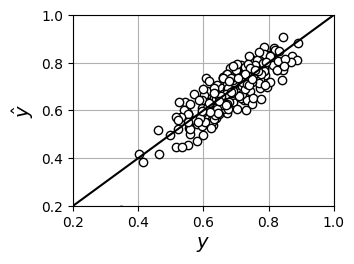

In [38]:
# Compare fit to model with 3 parameters (keep input variables 1,3,4)
# thetasparse = thetav[:, 87]
Xnew = X[:, [0, 2, 3]]
thetan = np.linalg.inv(Xnew.T.dot(Xnew)).dot(Xnew.T.dot(Y))
Yhat = Xnew.dot(thetan)
datnew = {'y': Y, 'X': Xnew}
MSEsparse = msefun(thetan, datnew)

plt.subplot(2, 2, 2)
plt.plot(Y, Yhat, 'o', markerfacecolor='w', color='black')
plt.plot([0, 1], [0, 1], 'k-')
plt.grid(True)
plt.xlabel('$y$', fontsize=14)
plt.ylabel('$\hat{y}$', fontsize=14)
plt.axis([0.2, 1, 0.2, 1])
plt.tight_layout()

<ipython-input-40-1d7079e0877d>:15: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.axis([0, 6, 0, 0.2])


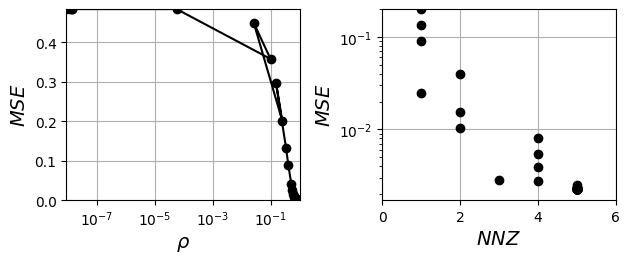

In [40]:
# Draw trade-off curve
plt.figure(2)
plt.subplot(2, 2, 1)
plt.semilogx(rho, MSE, 'o-', markerfacecolor='black', color='black')
plt.grid(True)
plt.xlabel('$\\rho$', fontsize=14)
plt.ylabel('$MSE$', fontsize=14)
plt.axis([min(rho), 1, 0, max(MSE)])

plt.subplot(2, 2, 2)
plt.semilogy(nnz, MSE, 'o', markerfacecolor='black', color='black')
plt.grid(True)
plt.xlabel('$NNZ$', fontsize=14)
plt.ylabel('$MSE$', fontsize=14)
plt.axis([0, 6, 0, 0.2])

plt.tight_layout()